In [1]:
import os,cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch,torchvision
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog,MetadataCatalog
from detectron2.model_zoo import get_checkpoint_url,get_config_file
from detectron2.engine import DefaultPredictor,DefaultTrainer
from detectron2.utils.visualizer import Visualizer,BoxMode
from sklearn.model_selection import train_test_split
from detectron2.evaluation import COCOEvaluator,DatasetEvaluator,DatasetEvaluator
import wandb
from tqdm import tqdm

In [2]:
data = pd.read_csv('./labels_train.csv').append(pd.read_csv('./labels_trainval.csv')).append(pd.read_csv('./labels_val.csv'))

In [3]:
data.head()

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,237,251,143,155,1
1,1478019952686311006.jpg,437,454,120,186,3
2,1478019953180167674.jpg,218,231,146,158,1
3,1478019953689774621.jpg,171,182,141,154,2
4,1478019953689774621.jpg,179,191,144,155,1


In [4]:
def load_data(data=data,test=False):
    if test is False:
        if 'dataset.npy' in os.listdir('./'):
            try:
                dataset = np.load('./dataset.npy',allow_pickle=True)
            except:
                dataset = np.loadtxt('./dataset.npy')
            return dataset
    if test is True:
        data = data[:1250]
    dataset = []
    for idx in tqdm(range(len(data))):
        record = {}
        info = data.iloc[idx]
        xmin,ymin,xmax,ymax = info['xmin'],info['ymin'],info['xmax'],info['ymax']
        height,width = cv2.imread('./images/' + info['frame']).shape[:2]
        record['file_name'] = './images/' + info['frame']
        record['height'] = height
        record['width'] = width
        info['class_id'] = info['class_id'] - 1
        record['cateogry_id'] = info['class_id']
        objs = [{'bbox':[info['xmin'],info['ymin'],info['xmax'],info['ymax']],'bbox_mode':BoxMode.XYXY_ABS,'iscrowd':0,'category_id':info['class_id']}]
        record['image_id'] = idx
        record['annotations'] = objs
        record['class_id'] = info['class_id']
        record['xmin'] = xmin
        record['ymin'] = ymin
        record['xmax'] = xmax
        record['ymax'] = ymax
        dataset.append(record)
    if test is False:
        if 'dataset.npy' not in os.listdir('./'):
            try:
                np.save('./dataset.npy',dataset)
            except:
                np.savetxt('./dataset.npy',dataset)
    return dataset

In [5]:
classes = ['car', 'truck', 'pedestrian', 'bicyclist', 'light']

In [6]:
DatasetCatalog.register('data',lambda : load_data())
MetadataCatalog.get('data').set(thing_classes=classes)
metadata = MetadataCatalog.get('data')

In [7]:
DatasetCatalog.register('test',lambda : load_data(test=True))
MetadataCatalog.get('test').set(thing_classes=classes)
metadata = MetadataCatalog.get('test')

In [8]:
# torch.cuda.empty_cache()
# wandb.init(sync_tensorboard=True,name='baseline')
# cfg = get_cfg()
# cfg.merge_from_file(get_config_file("COCO-Detection/faster_rcnn_R_101_DC5_3x.yaml"))
# cfg.DATASETS.TRAIN = ('data',)
# cfg.DATASETS.TEST = ('test',)
# cfg.WEIGHTS = get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_DC5_3x.yaml")
# cfg.SOLVER.MAX_ITER = 5000
# # cfg.TEST.EVAL_PERIOD = 50
# cfg.SOLVER.BASE_LR = 0.00025
# cfg.SOLVER.STEPS = []
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")v
# predictor = DefaultPredictor(cfg)

In [9]:
img = cv2.imread('./images/1478020243205145193.jpg')

In [10]:
img.shape

(300, 480, 3)

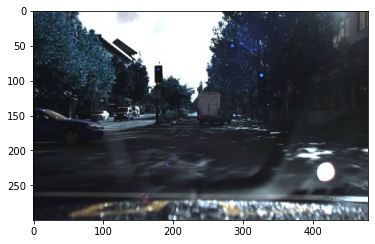

In [11]:
plt.imshow(img)

In [12]:
# v = Visualizer(img[:,:,::-1],metadata=metadata,scale=1)
# v = v.draw_instance_predictions(predictor(img)['instances'].to('cpu'))
# plt.figure(figsize=(10,7))
# plt.imshow(v.get_image()[:,:,::-1])
# plt.show()

In [13]:
from detectron2.data import build_detection_test_loader

In [14]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

In [15]:
# evaluator = COCOEvaluator('test', cfg, False, output_dir="./output/")
# val_loader = build_detection_test_loader(cfg, 'test')
# inference_on_dataset(trainer.model, val_loader, evaluator)

In [16]:
models = [
#     'faster_rcnn_R_101_C4_3x.yaml',
#     'faster_rcnn_R_101_DC5_3x.yaml',
#     'faster_rcnn_R_101_FPN_3x.yaml',
#     'faster_rcnn_R_50_C4_1x.yaml',
#     'faster_rcnn_R_50_C4_3x.yaml',
#     'faster_rcnn_R_50_DC5_1x.yaml',
#     'faster_rcnn_R_50_DC5_3x.yaml',
#     'faster_rcnn_R_50_FPN_1x.yaml',
#     'faster_rcnn_R_50_FPN_3x.yaml',
#     'faster_rcnn_X_101_32x8d_FPN_3x.yaml',
#     'faster_rcnn_R_101_DC5_3x.yaml'
]
# faster_rcnn_R_50_C4_1x.yaml

In [17]:
for model in models:
    torch.cuda.empty_cache()
    wandb.init(sync_tensorboard=True,name=model)
    cfg = get_cfg()
    cfg.merge_from_file(get_config_file(f'COCO-Detection/{model}'))
    cfg.DATASETS.TRAIN = ('data',)
    cfg.DATASETS.TEST = ()
    cfg.MODEL.WEIGHTS = get_checkpoint_url(f'COCO-Detection/{model}')
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 625
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    predictor = DefaultPredictor(cfg)
    v = Visualizer(img[:,:,::-1],metadata=metadata,scale=1)
    v = v.draw_instance_predictions(predictor(img)['instances'].to('cpu'))
    wandb.log({'image':wandb.Image(v.get_image()[:,:,::-1])})
    evaluator = COCOEvaluator('test',cfg,False,output_dir='./output')
    val_loader = build_detection_test_loader(cfg,'test')
    results = inference_on_dataset(trainer.model,val_loader,evaluator)
    wandb.log(results)
    wandb.finish()

In [18]:
BATCH_SIZE_PER_IMAGES = []
BASE_LRS = []
IMS_PER_BATCHS = []

In [19]:
# model = 'faster_rcnn_X_101_32x8d_FPN_3x.yaml'
# torch.cuda.empty_cache()
# wandb.init(sync_tensorboard=True,name=model)
# cfg = get_cfg()
# cfg.merge_from_file(get_config_file(f'COCO-Detection/{model}'))
# cfg.DATASETS.TRAIN = ('data',)
# cfg.DATASETS.TEST = ()
# cfg.MODEL.WEIGHTS = get_checkpoint_url(f'COCO-Detection/{model}')
# cfg.SOLVER.BASE_LR = 0.00025
# cfg.SOLVER.MAX_ITER = 625
# cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# predictor = DefaultPredictor(cfg)
# v = Visualizer(img[:,:,::-1],metadata=metadata,scale=1)
# v = v.draw_instance_predictions(predictor(img)['instances'].to('cpu'))
# wandb.log({'image':wandb.Image(v.get_image()[:,:,::-1])})
# evaluator = COCOEvaluator('test',cfg,False,output_dir='./output')
# val_loader = build_detection_test_loader(cfg,'test')
# results = inference_on_dataset(trainer.model,val_loader,evaluator)
# wandb.log(results)
# wandb.finish()

In [ ]:
wandb.init(sync_tensorboard=True)
model = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
cfg = get_cfg()
cfg.merge_from_file(get_config_file(model))
cfg.DATASETS.TRAIN = ('data',)
cfg.DATASETS.TEST = ()
cfg.MODEL.WEIGHTS = get_checkpoint_url(model)
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.ROI_HEADS.NUM_OF_CLASSES = len(classes)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
img = cv2.imread('./images/1478020243205145193.jpg')
preds = predictor(img)['instances']
v = Visualizer(img[:,:,::-1],metadata=metadata)
v = v.draw_instance_predictions(preds.to('cpu'))
v = v.get_image()[:,:,::-1]
wandb.log({'image':wandb.Image(v)})
# evaluator = COCOEvaluator('test',cfg,False,output_dir='./output/')
# val_loader = build_detection_test_loader(cfg,'test')
# result = inference_on_dataset(trainer.model,val_loader,evaluator)
# wandb.log(result)

wandb: Currently logged in as: ranuga-d (use `wandb login --relogin` to force relogin)


[06/11 08:52:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/home/indika/anaconda3/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[06/11 08:52:59 d2.utils.events]:  eta: 1:32:33  iter: 19  total_loss: 1.804  loss_cls: 1.474  loss_box_reg: 0.2164  loss_rpn_cls: 0.03112  loss_rpn_loc: 0.006729  time: 1.0668  data_time: 0.0358  lr: 4.9953e-06  max_mem: 5856M
[06/11 08:53:20 d2.utils.events]:  eta: 1:26:42  iter: 39  total_loss: 1.704  loss_cls: 1.388  loss_box_reg: 0.2269  loss_rpn_cls: 0.03956  loss_rpn_loc: 0.00743  time: 1.0515  data_time: 0.0026  lr: 9.9902e-06  max_mem: 5856M
[06/11 08:53:41 d2.utils.events]:  eta: 1:31:46  iter: 59  total_loss: 1.592  loss_cls: 1.291  loss_box_reg: 0.2138  loss_rpn_cls: 0.03545  loss_rpn_loc: 0.005099  time: 1.0497  data_time: 0.0027  lr: 1.4985e-05  max_mem: 5856M
[06/11 08:54:03 d2.utils.events]:  eta: 1:31:33  iter: 79  total_loss: 1.387  loss_cls: 1.046  loss_box_reg: 0.2479  loss_rpn_cls: 0.02363  loss_rpn_loc: 0.006665  time: 1.0598  data_time: 0.0027  lr: 1.998e-05  max_mem: 5856M
[06/11 08:54:24 d2.utils.events]:  eta: 1:31:15  iter: 99  total_loss: 1.007  loss_cls: 0.

In [ ]:
preds

In [ ]:
IMGS = ['1478020264690914781.jpg','1478020243205145193.jpg','1478020284690878247.jpg','1478020285197265564.jpg']
for IMG in IMGS:
    predictor = DefaultPredictor(cfg)
    img = cv2.imread(f'./images/{IMG}')
    v = Visualizer(img[:,:,::-1],metadata=metadata)
    v = v.draw_instance_predictions(predictor(img)['instances'].to('cpu'))
    plt.figure(figsize=(10,7))
    plt.imshow(v.get_image()[:,:,::-1])
    plt.show()